Assignment 1: https://ovgu-ailab.github.io/idl2020w/ass1.html


In [97]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import MNISTDataset
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


(60000, 28, 28)


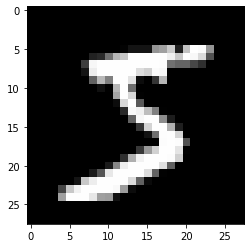

In [98]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


# since the image is 28 * 28 = 784 pixels. So, the input to the netwrok is 784.
data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

plt.imshow(train_images[0], cmap="Greys_r")
#print(train_images[0])
print(train_images.shape)



In [99]:
""" 
function generating the weights and paramters the network.
inputs = 784 for MNIST data set.
min_val & max_val specify the range for weights initialization.
bias_val = To initialize the biases.
hidden_units is a list that contain no. of neuron at each hidden layer.
"""
def network_generation(inputs, min_val, max_val, bias_val, hidden_units = [200,100,50]):
    j = 1
    weight_lst = [] 
    bias_lst = [] 
    weight_dict = {}
    bias_dict = {}
    for neuron in hidden_units:
      weight_lst.append('w_%d'%j)
      bias_lst.append('b_%d'%j)
      j+=1

    for param in range(len(weight_lst)):
      neuron = hidden_units[param]
      weight_dict[weight_lst[param]] = tf.Variable(tf.random.uniform(shape=[inputs, neuron], minval=min_val, maxval=max_val, dtype=tf.float32))
      bias_dict[bias_lst[param]] = tf.Variable(tf.constant(bias_val, shape=neuron, dtype=tf.float32))
      inputs = neuron

    return weight_dict, bias_dict

In [100]:
# sample o/p for function network_generation for network with 2 hidden units and 2 neurons each.
hidden_unit = [2,2]
weight_dict , bias_dict = network_generation(784,-0.1,0.1,1,hidden_unit)
print(weight_dict)
print(bias_dict)

{'w_1': <tf.Variable 'Variable:0' shape=(784, 2) dtype=float32, numpy=
array([[-0.00667262, -0.08560133],
       [ 0.06732772, -0.05189705],
       [-0.08704324, -0.03906634],
       ...,
       [ 0.07881511, -0.08459134],
       [-0.06078725,  0.09863601],
       [ 0.04393769, -0.08723328]], dtype=float32)>, 'w_2': <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.09801855, -0.07389717],
       [-0.04724658,  0.01540804]], dtype=float32)>}
{'b_1': <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>, 'b_2': <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>}


In [101]:
""" function for forward_prop """

def forward_prop(train_steps, data, hidden_units, weight_dict, bias_dict, activation, W_out, b_out):

    step_accuracy = []
    step_loss = []
    setp_epoch = []

    for step in range(train_steps):
      img_batch, lbl_batch = data.next_batch()

      hidden = list()
      with tf.GradientTape() as tape:
        for i in range(len(hidden_units)):
          hidden.append(activation(tf.matmul(img_batch, weight_dict[list(weight_dict.keys())[i]]) + bias_dict[list(bias_dict.keys())[i]]))
          img_batch = hidden[i]

        out = tf.matmul(hidden[-1], W_out) + b_out
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=out, labels=lbl_batch))

        weights = [weight_dict[k] for k in list(weight_dict.keys())]
        biases = [bias_dict[k] for k in list(bias_dict.keys())]

        total_layer =  weights + biases + [W_out, b_out]
        grads = tape.gradient(xent, total_layer)
        
        weight_grad = 0
        for k,v in weight_dict.items():
            weight_dict[k].assign_sub(learning_rate * grads[weight_grad])
            weight_grad+=1

        for k,v in bias_dict.items():
            bias_dict[k].assign_sub(learning_rate * grads[weight_grad])
            weight_grad+=1
        
        W_out.assign_sub(learning_rate * grads[weight_grad])
        weight_grad+=1
        b_out.assign_sub(learning_rate * grads[weight_grad])

        if not step % 100:
            preds = tf.argmax(out, axis=1, output_type=tf.int32)
            acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                                tf.float32))
            print("Loss: {} Accuracy: {}".format(xent, acc))
            step_accuracy.append(acc)
            step_loss.append(xent)
            setp_epoch.append(step)
        
    return step_accuracy, step_loss, setp_epoch, weight_dict, bias_dict, W_out, b_out

In [102]:
""" function for to calculate Accuracy on testing data."""
def prediction(data, hidden_units, weight_dict, bias_dict, activation, W_out, b_out):
    hidden = list()
    img_batch = data.test_data
    for i in range(len(hidden_units)):
        hidden.append(activation(tf.matmul(img_batch, weight_dict[list(weight_dict.keys())[i]]) + bias_dict[list(bias_dict.keys())[i]]))
        img_batch = hidden[i]

    out = tf.matmul(hidden[-1], W_out) + b_out

    test_preds = tf.argmax(tf.matmul(hidden[-1], W_out) + b_out, axis=1, output_type=tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),tf.float32))
    print("Accuracy on prediction data: ",acc)

Below is the network containing a single hidden layer of 200 neurons.
Activation function: relu


In [103]:
num_class = 10
train_steps = 7000
learning_rate = 0.1
hidden_units = [200]
activation = tf.nn.relu


W_out = tf.Variable(tf.random.uniform(shape=[200, num_class], minval=-1, maxval=1, dtype=tf.float32))
b_out = tf.Variable(tf.constant(0, shape=num_class, dtype=tf.float32))

weight_dict, bias_dict = network_generation(784, -1, 1, 0, hidden_units)
accuracy, loss, epoch, weight, bias, out_wt, out_bias = forward_prop(train_steps, data, hidden_units, weight_dict, bias_dict, activation, W_out, b_out)

prediction(data, hidden_units, weight, bias, activation, out_wt, out_bias)

Loss: 62.76837158203125 Accuracy: 0.0546875
Loss: 3.6910440921783447 Accuracy: 0.7265625
Loss: 1.7380681037902832 Accuracy: 0.8359375
Loss: 1.1944210529327393 Accuracy: 0.8984375
Loss: 0.780323326587677 Accuracy: 0.90625
Starting new epoch...
Loss: 0.7964587807655334 Accuracy: 0.8828125
Loss: 0.6326226592063904 Accuracy: 0.890625
Loss: 0.41700467467308044 Accuracy: 0.9375
Loss: 0.235131174325943 Accuracy: 0.921875
Loss: 0.589575469493866 Accuracy: 0.9296875
Starting new epoch...
Loss: 0.519894003868103 Accuracy: 0.875
Loss: 0.43872132897377014 Accuracy: 0.9375
Loss: 0.6925572752952576 Accuracy: 0.90625
Loss: 0.3576883375644684 Accuracy: 0.921875
Loss: 0.4398546814918518 Accuracy: 0.9296875
Starting new epoch...
Loss: 0.7232489585876465 Accuracy: 0.8984375
Loss: 0.22047318518161774 Accuracy: 0.9296875
Loss: 0.5236872434616089 Accuracy: 0.9140625
Loss: 0.38888442516326904 Accuracy: 0.9140625
Starting new epoch...
Loss: 0.042916566133499146 Accuracy: 0.9921875
Loss: 0.1772768497467041 Acc

In [104]:
def plotgraph(plots):
    for i in [0,1 ]:
      fig = plt.figure(figsize=(15,5))
      ax = fig.add_subplot(1,3,i+1)
      ax.grid()
      plt.plot(epoch, plots[i])
      plt.show()

Graphs for Accuracy and Loss values

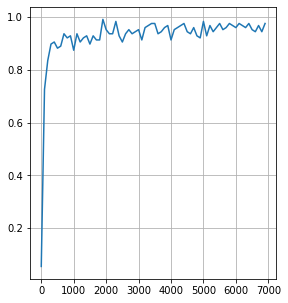

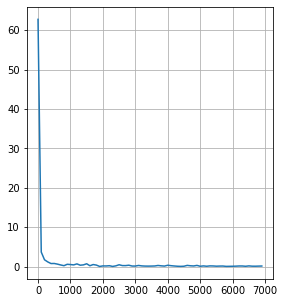

In [105]:
plotgraph([accuracy, loss])

Below is the network consisting of 2 hidden layers of 50 and 200 neurons, trained for 4000 epochs, with the learning rate of 0.1
Activation function: relu

In [106]:
num_class = 10
train_steps = 4000
learning_rate = 0.1
hidden_units = [50,200]
activation = tf.nn.relu

W_out = tf.Variable(tf.random.uniform(shape=[200, num_class], minval=-1, maxval=1, dtype=tf.float32))
b_out = tf.Variable(tf.constant(0, shape=num_class, dtype=tf.float32))

weight_dict, bias_dict = network_generation(784, -1, 1, 0, hidden_units)
accuracy, loss, epoch, weight, bias, out_wt, out_bias = forward_prop(train_steps, data, hidden_units, weight_dict, bias_dict, activation, W_out, b_out)

prediction(data, hidden_units, weight, bias, activation, out_wt, out_bias)

Loss: 116.44566345214844 Accuracy: 0.09375
Starting new epoch...
Loss: 2.0545756816864014 Accuracy: 0.3046875
Loss: 1.6672892570495605 Accuracy: 0.40625
Loss: 1.67434561252594 Accuracy: 0.4296875
Loss: 1.3867971897125244 Accuracy: 0.5703125
Loss: 1.342388391494751 Accuracy: 0.5078125
Starting new epoch...
Loss: 1.3995106220245361 Accuracy: 0.578125
Loss: 1.5550861358642578 Accuracy: 0.5703125
Loss: 1.126440405845642 Accuracy: 0.6875
Loss: 1.3147218227386475 Accuracy: 0.625
Starting new epoch...
Loss: 1.0710885524749756 Accuracy: 0.6953125
Loss: 0.8645374774932861 Accuracy: 0.7734375
Loss: 0.7243316769599915 Accuracy: 0.734375
Loss: 1.407801866531372 Accuracy: 0.65625
Loss: 0.5546558499336243 Accuracy: 0.84375
Starting new epoch...
Loss: 0.8828940391540527 Accuracy: 0.6875
Loss: 1.0291197299957275 Accuracy: 0.6875
Loss: 0.6633627414703369 Accuracy: 0.765625
Loss: 0.6580823659896851 Accuracy: 0.8359375
Loss: 0.6374828815460205 Accuracy: 0.8203125
Starting new epoch...
Loss: 0.58773910999

Plots for the accurcy and loss for training data for the above trained network

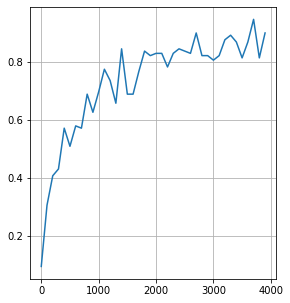

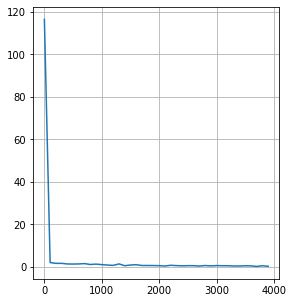

In [107]:
plotgraph([accuracy, loss])

Network with three hidden units consiting of 50,150 and 200 neurons, with the learning rate value of 0.01 , trained for 4000 epochs.
Activation function: tanh

In [108]:
num_class = 10
train_steps = 4000
learning_rate = 0.01
hidden_units = [50,150,200]
activation = tf.nn.tanh

W_out = tf.Variable(tf.random.uniform(shape=[200, num_class], minval=-1, maxval=1, dtype=tf.float32))
b_out = tf.Variable(tf.constant(0, shape=num_class, dtype=tf.float32))

weight_dict, bias_dict = network_generation(784, -1, 1, 0, hidden_units)
accuracy, loss, epoch, weight, bias, out_wt, out_bias = forward_prop(train_steps, data, hidden_units, weight_dict, bias_dict, activation, W_out, b_out)

prediction(data, hidden_units, weight, bias, activation, out_wt, out_bias)

Loss: 11.860147476196289 Accuracy: 0.078125
Loss: 7.127269744873047 Accuracy: 0.2109375
Loss: 4.599708557128906 Accuracy: 0.5
Starting new epoch...
Loss: 3.7488086223602295 Accuracy: 0.4765625
Loss: 2.6072659492492676 Accuracy: 0.59375
Loss: 2.667738437652588 Accuracy: 0.59375
Loss: 2.8567423820495605 Accuracy: 0.5703125
Loss: 2.66267728805542 Accuracy: 0.6328125
Starting new epoch...
Loss: 1.522003173828125 Accuracy: 0.6796875
Loss: 2.4497289657592773 Accuracy: 0.625
Loss: 1.5259604454040527 Accuracy: 0.671875
Loss: 1.4480880498886108 Accuracy: 0.7265625
Starting new epoch...
Loss: 1.7033860683441162 Accuracy: 0.734375
Loss: 1.3262255191802979 Accuracy: 0.703125
Loss: 1.2032438516616821 Accuracy: 0.7890625
Loss: 1.6591236591339111 Accuracy: 0.6796875
Loss: 1.5956379175186157 Accuracy: 0.765625
Starting new epoch...
Loss: 1.2370805740356445 Accuracy: 0.78125
Loss: 1.7710323333740234 Accuracy: 0.7578125
Loss: 0.9324479699134827 Accuracy: 0.796875
Loss: 1.4525519609451294 Accuracy: 0.757

Plots depicting the accuracy and loss value for the above network.

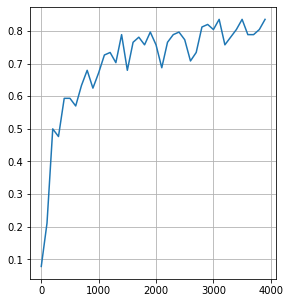

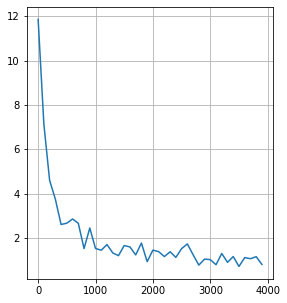

In [109]:
plotgraph([accuracy, loss])

**MNIST Fashion Data set** 

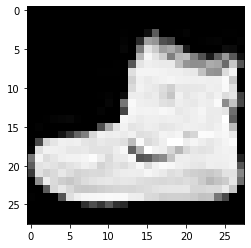

In [110]:
mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

plt.imshow(train_images[0], cmap="Greys_r")

data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

In [111]:
num_class = 10
train_steps = 4000
learning_rate = 0.01
hidden_units = [200]
activation = tf.nn.relu

W_out = tf.Variable(tf.random.uniform(shape=[200, num_class], minval=-1, maxval=1, dtype=tf.float32))
b_out = tf.Variable(tf.constant(0, shape=num_class, dtype=tf.float32))

weight_dict, bias_dict = network_generation(784, -1, 1, 0, hidden_units)
accuracy, loss, epoch, weight, bias, out_wt, out_bias = forward_prop(train_steps, data, hidden_units, weight_dict, bias_dict, activation, W_out, b_out)

prediction(data, hidden_units, weight, bias, activation, out_wt, out_bias)

Loss: 57.58604431152344 Accuracy: 0.0078125
Loss: 4.510759353637695 Accuracy: 0.6328125
Loss: 6.881874084472656 Accuracy: 0.5546875
Loss: 5.645758152008057 Accuracy: 0.671875
Loss: 3.9256107807159424 Accuracy: 0.6640625
Starting new epoch...
Loss: 3.910831928253174 Accuracy: 0.6796875
Loss: 2.990933418273926 Accuracy: 0.6875
Loss: 3.5026464462280273 Accuracy: 0.703125
Loss: 1.8582568168640137 Accuracy: 0.796875
Loss: 2.8279967308044434 Accuracy: 0.7265625
Starting new epoch...
Loss: 3.058070421218872 Accuracy: 0.734375
Loss: 1.5966814756393433 Accuracy: 0.8125
Loss: 1.5409321784973145 Accuracy: 0.7578125
Loss: 2.779524326324463 Accuracy: 0.6796875
Loss: 2.524130344390869 Accuracy: 0.7265625
Starting new epoch...
Loss: 1.8432848453521729 Accuracy: 0.796875
Loss: 2.1348681449890137 Accuracy: 0.796875
Loss: 1.258917212486267 Accuracy: 0.8359375
Loss: 1.2406771183013916 Accuracy: 0.8359375
Starting new epoch...
Loss: 0.9504184722900391 Accuracy: 0.7734375
Loss: 0.9936774969100952 Accuracy:

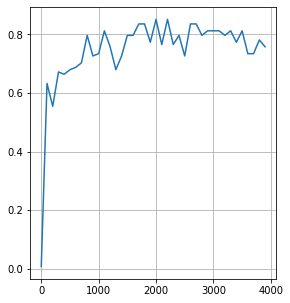

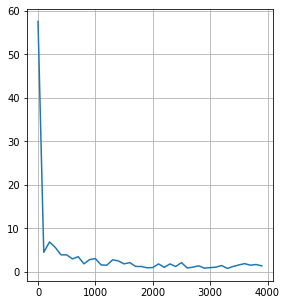

In [112]:
plotgraph([accuracy, loss])

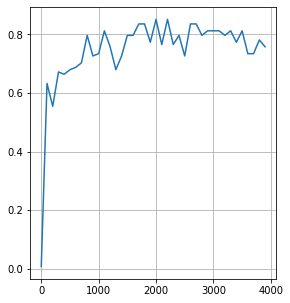

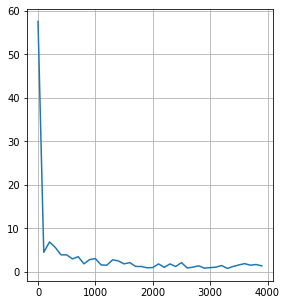

In [113]:
plotgraph([accuracy,loss])

In [114]:
num_class = 10
train_steps = 4000
learning_rate = 0.1
hidden_units = [50, 150]
activation = tf.nn.tanh

W_out = tf.Variable(tf.random.uniform(shape=[150, num_class], minval=-1, maxval=1, dtype=tf.float32))
b_out = tf.Variable(tf.constant(0, shape=num_class, dtype=tf.float32))

weight_dict, bias_dict = network_generation(784, -1, 1, 0, hidden_units)
accuracy, loss, epoch, weight, bias, out_wt, out_bias = forward_prop(train_steps, data, hidden_units, weight_dict, bias_dict, activation, W_out, b_out)

prediction(data, hidden_units, weight, bias, activation, out_wt, out_bias)

Loss: 10.110072135925293 Accuracy: 0.0390625
Loss: 1.1316174268722534 Accuracy: 0.6796875
Loss: 0.8068944811820984 Accuracy: 0.7265625
Starting new epoch...
Loss: 0.8414962291717529 Accuracy: 0.6875
Loss: 0.9559849500656128 Accuracy: 0.703125
Loss: 1.0528582334518433 Accuracy: 0.6875
Loss: 0.6729953289031982 Accuracy: 0.78125
Starting new epoch...
Loss: 0.7039480209350586 Accuracy: 0.71875
Loss: 0.5375185012817383 Accuracy: 0.796875
Loss: 0.755151629447937 Accuracy: 0.71875
Loss: 0.6991528868675232 Accuracy: 0.7265625
Loss: 0.5503082275390625 Accuracy: 0.7890625
Starting new epoch...
Loss: 0.7451468706130981 Accuracy: 0.75
Loss: 0.5633894801139832 Accuracy: 0.7890625
Loss: 0.6809872388839722 Accuracy: 0.7421875
Loss: 0.56001216173172 Accuracy: 0.796875
Loss: 0.6715667247772217 Accuracy: 0.734375
Starting new epoch...
Loss: 0.4724023938179016 Accuracy: 0.8515625
Loss: 0.6148360967636108 Accuracy: 0.75
Loss: 0.5262647867202759 Accuracy: 0.78125
Loss: 0.5324080586433411 Accuracy: 0.835937

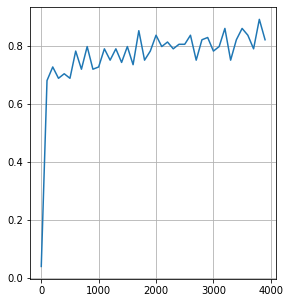

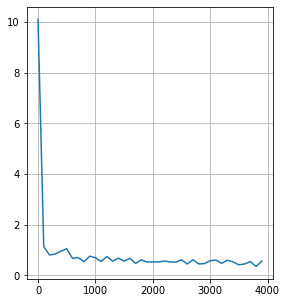

In [115]:
plotgraph([accuracy,loss])

currently we are making the network by defining the architecture manually multiplying the weights with the input and passing this as input to the next layer, this entire
functionality in one function.

Parameters such as num_hidden layers, epochs, learning_rate should not be defined again and again, rather should be coming from a config, where changing the values in function 
should be able to run the training.